<a href="https://colab.research.google.com/github/jaehakimm/Langgraph/blob/main/Langgraph2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Router

Router = Chat model routes between a direct response or a tool call based upon the user input

Let's start to simple example of this

For this, use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [3]:
from langchain_openai import ChatOpenAI

def minus (a:int, b:int) -> int:
  "Minus a-b"
  return a-b

llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_tools = llm.bind_tools([minus])


Now have tool node call minus.

Let's create tool_condition to be condition edge

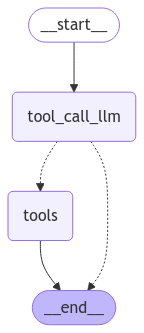

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#node
def tool_call_llm (state : MessagesState):
    return {"messages": [llm_tools.invoke(state["messages"])]}

#Start build Graph
builder = StateGraph(MessagesState)
builder.add_node("tool_call_llm", tool_call_llm)
builder.add_node("tools",ToolNode([minus]))
builder.add_edge(START, "tool_call_llm")
builder.add_conditional_edges(
    "tool_call_llm", tools_condition,
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
)
builder.add_edge("tools", END)
graph = builder.compile()

#visualize graph
display(Image(graph.get_graph().draw_mermaid_png()))


# Let's Test
Let's test our simple router LangGraph

In [5]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello world.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I assist you today?


In [6]:
messages = [HumanMessage(content="what is 400-200")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 400-200
================================== Ai Message ==================================
Tool Calls:
  minus (call_1Js2hTZYIxOLLo8w2KeYLp7B)
 Call ID: call_1Js2hTZYIxOLLo8w2KeYLp7B
  Args:
    a: 400
    b: 200
================================= Tool Message =================================
Name: minus

200


# Agent

In the above router,  invoked the model and, if it chose to call a tool, we returned a "ToolMessage" to the user.
But,if simpily pass "ToolMessage" back to model, what will happend next ?

> let 1 call to another tool or 2 respond directly

**This is the intuition behind ReAct, a general agent architecture.**


> act = let model call specific tools

> observe - pass the tool output back to the model

> reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)







In [8]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph"

LANGCHAIN_API_KEY: ··········


In [9]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiplies two integers.

    Args:
        a: The first integer.
        b: The second integer.

    Returns:
        The product of a and b.
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds two integers.

    Args:
        a: The first integer.
        b: The second integer.

    Returns:
        The sum of a and b.
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divides two integers.

    Args:
        a: The first integer.
        b: The second integer.

    Returns:
        The result of dividing a by b.
    """
    return a / b

tool =[multiply,add,divide]
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_tool = llm.bind_tools(tool, parallel_tool_calls=False)

Create llm and prompt over all desired agent behavior

In [10]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage,SystemMessage

system_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

#node
def assistant (state : MessagesState):
    return {"messages":[llm_tool.invoke([system_msg] + state["messages"])]}


As before start with "MessagesState" and defind tool node with all list tools

> **assistant node = model with tool **

Create a graph with Assistant and Tools nodes.

add ***tools_condition*** edge, which routes to ***End*** or to Tools based on whether the ***Assistant*** calls a tool.



> **Now Add more new step**

connect the Tools node back to the Assistant, forming a loop.







*   After the assistant node executes, tools_condition checks if the model's output is a tool call.
*   If it is a tool call, the flow is directed to the tools node.
*   The tools node connects back to assistant.
*   This loop continues as long as the model decides to call tools.
*   If the model response is not a tool call, the flow is directed to END, terminating the process.




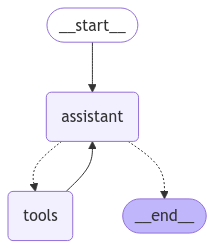

In [11]:
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

#Graph
builder = StateGraph(MessagesState)

#define node
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tool))

#define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")
graph_react = builder.compile()

#visualiz Graph
display(Image(graph_react.get_graph(xray=True).draw_mermaid_png()))

Let Test !!!

In [12]:
messages = [HumanMessage(content="Add 70 and 5. Multiply the output by 40. Divide the output by 37")]
messages = graph_react.invoke({"messages": messages})
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 70 and 5. Multiply the output by 40. Divide the output by 37
================================== Ai Message ==================================
Tool Calls:
  add (call_syScmGo0Gxrs2dFR0PwVIyj1)
 Call ID: call_syScmGo0Gxrs2dFR0PwVIyj1
  Args:
    a: 70
    b: 5
================================= Tool Message =================================
Name: add

75
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZApwe3GlnfBQfMtdfewunzva)
 Call ID: call_ZApwe3GlnfBQfMtdfewunzva
  Args:
    a: 75
    b: 40
================================= Tool Message =================================
Name: multiply

3000
================================== Ai Message ==================================
Tool Calls:
  divide (call_eeYH2PuQTwjG3HfPWvckVjFE)
 Call ID: call_eeYH2PuQTwjG3HfPWvckVjFE
  Args:
    a: 3000
    b: 37
================================= Tool Message ===

# Agent with Memory
LLM is stateless, no memory. Use "MemorySaver" to be a key - value for memory store Graph State

In [14]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_react_memory = builder.compile(checkpointer=memory)

One Thing that important is when use Memory, need to set config specify "Thread id" as like Langchain (That learn in M.A.D LLM Module KBTG)

This thread_id will store our collection of graph states.



*   Checkpointer write state every step of graph
*   all checkpoint that wrote state every step of graph will be saved in thread id
*   Can access thread in next time use thread id



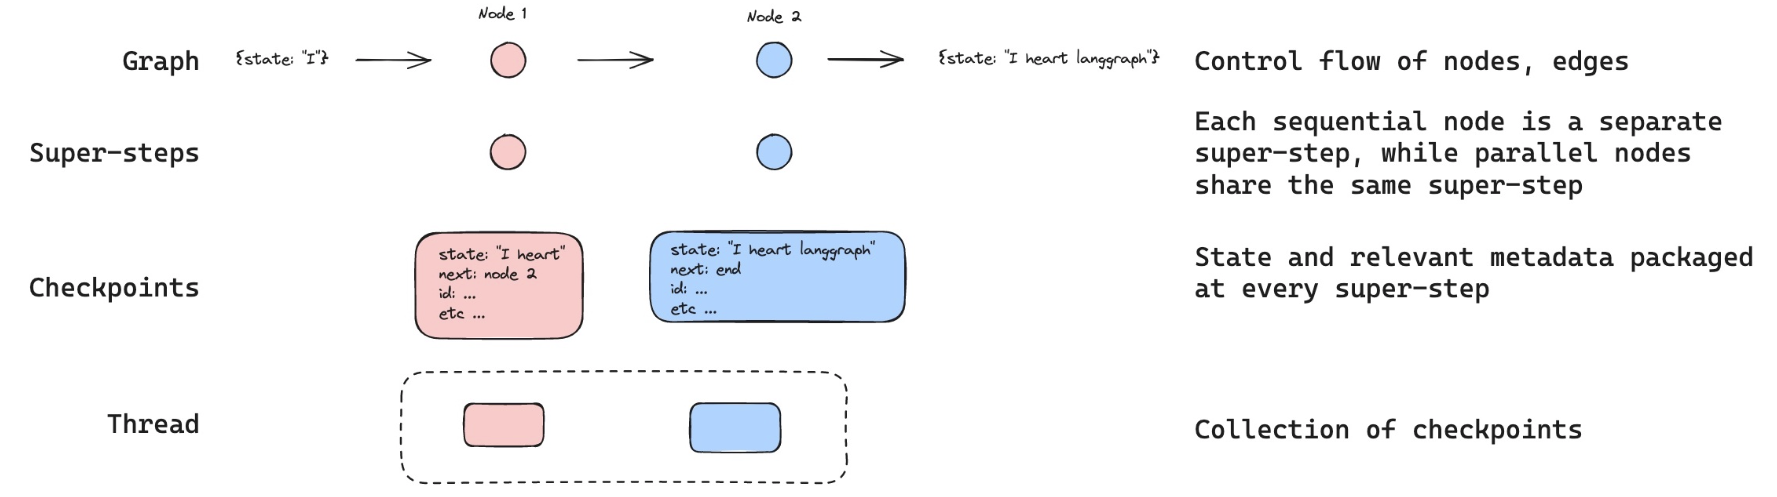

In [15]:
#set config for thread
config = {"configurable" : {"thread_id": 1}}

messages = [HumanMessage(content="Add 12 and 5")]

#test run
messages = graph_react_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 12 and 5
================================== Ai Message ==================================
Tool Calls:
  add (call_gkQECuUh5rz4mmnh5wvcTaP9)
 Call ID: call_gkQECuUh5rz4mmnh5wvcTaP9
  Args:
    a: 12
    b: 5
================================= Tool Message =================================
Name: add

17
================================== Ai Message ==================================

The sum of 12 and 5 is 17.


From now already pass "Threadid" in config in to graph

```
config = {"configurable" : {"thread_id": 1}}
```

So let check memory if pass same thread_id : 1 will continue conversation or not





In [16]:
messages = [HumanMessage(content="Multiply 4 minus 2")]
messages = graph_react_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 12 and 5
================================== Ai Message ==================================
Tool Calls:
  add (call_gkQECuUh5rz4mmnh5wvcTaP9)
 Call ID: call_gkQECuUh5rz4mmnh5wvcTaP9
  Args:
    a: 12
    b: 5
================================= Tool Message =================================
Name: add

17
================================== Ai Message ==================================

The sum of 12 and 5 is 17.
================================ Human Message =================================

Multiply 4 minus 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_5XRaf7IlffYcTlBZ71e6TYzo)
 Call ID: call_5XRaf7IlffYcTlBZ71e6TYzo
  Args:
    a: 4
    b: -2
================================= Tool Message =================================
Name: multiply

-8
================================== Ai Message ==================================

The result of mul